In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters

In [2]:
%matplotlib inline

In [3]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf
import prepare_sat_data as prep

In [4]:
importlib.reload(prep)

<module 'prepare_sat_data' from '/home/travis/python_code/letkf_forecasting/prepare_sat_data.py'>

In [ ]:
sat_data = xr.open_dataset('/a2/uaren/goes_images/crop/sat_images.nc')

In [ ]:
elevation_data = xr.open_dataset(
    '/home/travis/python_code/letkf_forecasting/elevation_data.nc')

In [ ]:
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

In [ ]:
midday_sat = prep.midday(sat_data, tus, 60)

In [ ]:
midday_sat.to_netcdf('midday_interp_sat.nc')

In [ ]:
midday_sat = xr.open_dataset('./midday_interp_sat.nc')

In [ ]:
this = midday_sat.data.values
shape = this.shape
these_times = pd.to_datetime(
    midday_sat.time).tz_localize('UTC').tz_convert('MST')
midday_sat_dataframe = pd.DataFrame(this.reshape(shape[0], shape[1]*shape[2]), index=these_times)

In [ ]:
midday_sat_dataframe.to_hdf('./data/pixel.h5', 'pixel')

In [ ]:
domain_shape = shape[1:]
np.save('./data/domain_shape', domain_shape)

In [ ]:
elevation = elevation_data.elevation.values.ravel()
lats = midday_sat.lat.values.ravel()
lons = midday_sat.lon.values.ravel()
x = midday_sat.x.values.ravel()
y = midday_sat.y.values.ravel()
np.save('./data/elevation', elevation)
np.save('./data/lats', lats)
np.save('./data/lons', lons)
np.save('./data/x', x)
np.save('./data/y', y)

In [5]:
pixel = pd.read_hdf('./data/pixel.h5')
domain_shape = np.load('./data/domain_shape.npy')
elevation = np.load('./data/elevation.npy')
x = np.load('./data/x.npy')
y = np.load('./data/y.npy')
lats = np.load('./data/lats.npy')
lons = np.load('./data/lons.npy')

In [ ]:
importlib.reload(prep)
low, up, cloudiness_index = prep.get_cloudiness_index(pixel, lats, lons, elevation)

In [ ]:
np.save('./data/low', low)
np.save('./data/up', up)
cloudiness_index.to_hdf(
    './data/cloudiness_index.h5', 'cloudiness_index')

In [15]:
low = np.load('./data/low.npy')
up = np.load('./data/up.npy')
cloudiness_index = pd.read_hdf('./data/cloudiness_index.h5')

In [7]:
importlib.reload(prep)
clearsky = prep.get_clearsky(pixel.index, elevation, lats, lons)

zenith
turbidity
ones
LT
elev
cgs
I0
fh


In [8]:
clearsky.to_hdf('./data/clearsky.h5', 'clearsky')

In [10]:
clearsky.shape

(2607, 131044)

In [44]:
this_time = pd.Timestamp('2014-04-15 12:45:00').tz_localize('MST')
CI = cloudiness_index.ix[this_time].reshape(domain_shape).copy()
ktm = 2.36*CI**5 - 6.2*CI**4 + 6.22*CI**3 - 2.63*CI**2 - 0.58*CI + 1
Ghcnew = clearsky.ix[this_time].reshape(domain_shape).copy()
GHI = ktm*Ghcnew*(0.0001*ktm*Ghcnew + 0.9)

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [48]:
this_time = pd.Timestamp('2014-04-14 12:45:00').tz_localize('MST')
CI_c = cloudiness_index.ix[this_time].reshape(domain_shape).copy()
ktm_c = 2.36*CI_c**5 - 6.2*CI_c**4 + 6.22*CI_c**3 - 2.63*CI_c**2 - 0.58*CI_c + 1
Ghcnew_c = clearsky.ix[this_time].reshape(domain_shape).copy()
GHI_c = ktm_c*Ghcnew_c*(0.0001*ktm_c*Ghcnew_c + 0.9)

/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/home/travis/miniconda3/envs/py35Solar/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


1.02286039683
0.825590036141


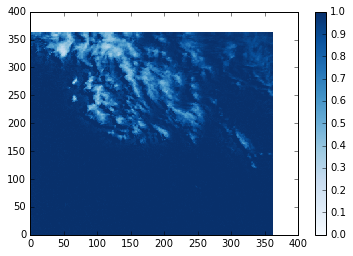

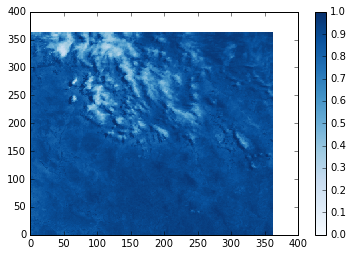

In [49]:
plt.figure()
this_image = GHI/GHI_c
print(this_image.max() - this_image.min())
im = plt.pcolormesh(
    this_image,
    cmap='Blues',
    vmin=0, vmax=1)
plt.colorbar(im)

plt.figure()
this_image = GHI/Ghcnew
print(this_image.max() - this_image.min())
im = plt.pcolormesh(
    this_image,
    cmap='Blues',
    vmin=0, vmax=1)
plt.colorbar(im)